In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Setting up Data
import tensorflow as tf
from sklearn import preprocessing
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES']='1' 
tf.reset_default_graph()
%matplotlib inline

C:\E_Disk\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#中冷后进气压力/进气量/ 中冷后进气温度/冷却水温度/ EGR阀开度/实测氧浓度/实测碳烟排放
data = pd.read_csv("../data/data_train.csv")
data = data.dropna()
data = data[['AIR_FLOW','CEXREAL','NE','PIM','QFIN','THA','THW','soot']]
print(data.shape)

(149503, 8)


In [3]:
#删除97000--100000范围的数据
data['soot'][97000:100000] = -1
data_la = data[data['soot'] != -1]
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#f = lambda x : 20 if x>20 else x
#data2 = data['soot'].map(f)
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
#data_la['soot'] = data_la['soot'].apply( lambda x: 20 if x>20 else x)
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.2 if (x < 0.3) & (x >0.1) else x)  
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.15 if x<0.3 else x)

C:\E_Disk\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys



 mu = 1.37 and sigma = 1.20



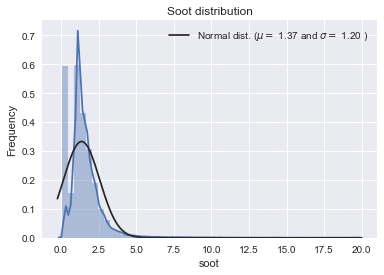

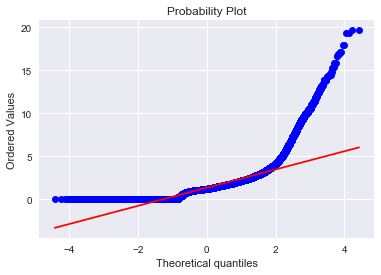

In [4]:
from scipy import stats
from scipy.stats import norm, skew

sns.distplot(data_la['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data_la['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data_la['soot'], plot=plt)
plt.show()

C:\E_Disk\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



 mu = 1.32 and sigma = 1.24



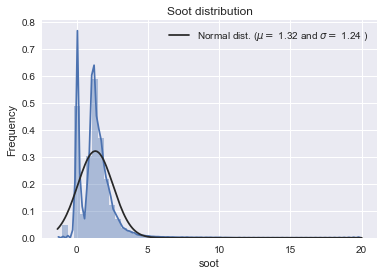

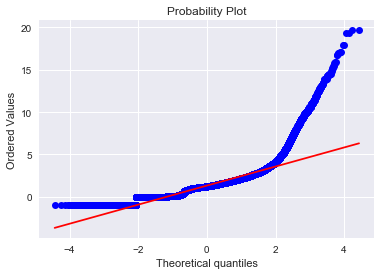

In [5]:
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data_la['soot'] = np.log1p(data_la['soot'])

#Check the new distribution 
sns.distplot(data['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['soot'], plot=plt)
plt.show()

In [6]:
features =  data_la.columns.values[0:7]   
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
data = data_la
n_train_days = int(len(data)*0.9)
data = data
#前80% 天的数据作为训练数据
train = data[:n_train_days]

#最后20%天的数据作为验证数据
test = data[n_train_days:]


In [7]:
#设定输入输出
train_X, train_y = train[features].values, train['soot'].values
train_y = train_y.reshape(train_y.shape[0],1)

test_X, test_y = test[features].values, test['soot'].values
test_y  = test_y.reshape(test_y.shape[0],1)
from sklearn import  preprocessing
train_X = preprocessing.scale(train_X)
test_X = preprocessing.scale(test_X)
print(test_X.shape,test_y.shape)

(14651, 7) (14651, 1)


In [8]:
train_X.shape,train_y.shape

((131852, 7), (131852, 1))

In [9]:
#设计网络结构  #网络设计的不好，不会收敛，每层神经元数，dropout大小,layers数都会有影响
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense,Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization   #加入BN层效果显著，明显收敛
from keras.optimizers import SGD
from keras.callbacks import TensorBoard 

#在第一个隐层中定义具有50个神经元的LSTM和用于预测close的
#输出层中的1个神经元，输入形状是1个时间步长，具有5个特征。
model = Sequential()
model.add(Dense(7,input_dim = 7))
model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(Dense(7))
model.add(Activation('relu'))  #/tanh/sigmoid/linear
#model.add(Dropout(0.8))
model.add(Dense(4))
model.add(Activation('relu'))
model.add(Dense(1))
#model.add(Activation('relu'))
model.add(BatchNormalization()) #有无
#sgd = SGD(lr=0.001, momentum=0.009, decay=0.0, nesterov=False)
adam = Adam(lr=0.0005, beta_1=0.09, beta_2=0.999, epsilon=1e-8)  #0.0005\0.005/0.01/0.015
model.compile(loss='mse', optimizer=adam,metrics=['mae'])

#使用平均绝对误差（MAE）损失函数。该模型将拟合50个批量大小为64的
#训练时期。通过在fit（）函数中设置validation_data参数来跟踪训练
#过程中的训练和测试失败
#epochs和batch_size调了好长时间效果一直不好
history = model.fit(train_X, train_y, nb_epoch=500, batch_size=1000, validation_data=(test_X, test_y),verbose=2, shuffle=False)
#score = model.evaluate(train_X, train_y,batch_size=360)


Using TensorFlow backend.
C:\E_Disk\anaconda\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 131852 samples, validate on 14651 samples
Epoch 1/500
 - 1s - loss: 1.1754 - mean_absolute_error: 0.8107 - val_loss: 1.5680 - val_mean_absolute_error: 0.9344
Epoch 2/500
 - 0s - loss: 0.9032 - mean_absolute_error: 0.7384 - val_loss: 0.8185 - val_mean_absolute_error: 0.6870
Epoch 3/500
 - 0s - loss: 0.7244 - mean_absolute_error: 0.6693 - val_loss: 0.4555 - val_mean_absolute_error: 0.5240
Epoch 4/500
 - 0s - loss: 0.5906 - mean_absolute_error: 0.6065 - val_loss: 0.2874 - val_mean_absolute_error: 0.4144
Epoch 5/500
 - 0s - loss: 0.4628 - mean_absolute_error: 0.5444 - val_loss: 0.1296 - val_mean_absolute_error: 0.2670
Epoch 6/500
 - 0s - loss: 0.3113 - mean_absolute_error: 0.4731 - val_loss: 0.1233 - val_mean_absolute_error: 0.2606
Epoch 7/500
 - 0s - loss: 0.2536 - mean_absolute_error: 0.4276 - val_loss: 0.1249 - val_mean_absolute_error: 0.2546
Epoch 8/500
 - 0s - loss: 0.2132 - mean_absolute_error: 0.3860 - val_loss: 0.1129 - val_mean_absolute_error: 0.2372
Epoch 9/500
 - 0s - l

Epoch 71/500
 - 0s - loss: 0.0565 - mean_absolute_error: 0.1593 - val_loss: 0.0555 - val_mean_absolute_error: 0.1550
Epoch 72/500
 - 0s - loss: 0.0562 - mean_absolute_error: 0.1587 - val_loss: 0.0547 - val_mean_absolute_error: 0.1546
Epoch 73/500
 - 0s - loss: 0.0559 - mean_absolute_error: 0.1582 - val_loss: 0.0610 - val_mean_absolute_error: 0.1793
Epoch 74/500
 - 0s - loss: 0.0557 - mean_absolute_error: 0.1577 - val_loss: 0.0556 - val_mean_absolute_error: 0.1609
Epoch 75/500
 - 0s - loss: 0.0555 - mean_absolute_error: 0.1573 - val_loss: 0.0544 - val_mean_absolute_error: 0.1566
Epoch 76/500
 - 0s - loss: 0.0553 - mean_absolute_error: 0.1569 - val_loss: 0.0565 - val_mean_absolute_error: 0.1582
Epoch 77/500
 - 0s - loss: 0.0551 - mean_absolute_error: 0.1566 - val_loss: 0.0543 - val_mean_absolute_error: 0.1569
Epoch 78/500
 - 0s - loss: 0.0549 - mean_absolute_error: 0.1562 - val_loss: 0.0533 - val_mean_absolute_error: 0.1525
Epoch 79/500
 - 0s - loss: 0.0547 - mean_absolute_error: 0.1557 

Epoch 141/500
 - 0s - loss: 0.0480 - mean_absolute_error: 0.1398 - val_loss: 0.0522 - val_mean_absolute_error: 0.1599
Epoch 142/500
 - 0s - loss: 0.0479 - mean_absolute_error: 0.1397 - val_loss: 0.0527 - val_mean_absolute_error: 0.1617
Epoch 143/500
 - 0s - loss: 0.0479 - mean_absolute_error: 0.1396 - val_loss: 0.0493 - val_mean_absolute_error: 0.1500
Epoch 144/500
 - 0s - loss: 0.0479 - mean_absolute_error: 0.1395 - val_loss: 0.0508 - val_mean_absolute_error: 0.1552
Epoch 145/500
 - 0s - loss: 0.0478 - mean_absolute_error: 0.1394 - val_loss: 0.0485 - val_mean_absolute_error: 0.1437
Epoch 146/500
 - 0s - loss: 0.0478 - mean_absolute_error: 0.1393 - val_loss: 0.0490 - val_mean_absolute_error: 0.1489
Epoch 147/500
 - 0s - loss: 0.0478 - mean_absolute_error: 0.1393 - val_loss: 0.0499 - val_mean_absolute_error: 0.1494
Epoch 148/500
 - 0s - loss: 0.0477 - mean_absolute_error: 0.1392 - val_loss: 0.0524 - val_mean_absolute_error: 0.1608
Epoch 149/500
 - 0s - loss: 0.0477 - mean_absolute_error

Epoch 211/500
 - 0s - loss: 0.0456 - mean_absolute_error: 0.1345 - val_loss: 0.0444 - val_mean_absolute_error: 0.1297
Epoch 212/500
 - 0s - loss: 0.0456 - mean_absolute_error: 0.1345 - val_loss: 0.0471 - val_mean_absolute_error: 0.1406
Epoch 213/500
 - 0s - loss: 0.0456 - mean_absolute_error: 0.1345 - val_loss: 0.0452 - val_mean_absolute_error: 0.1331
Epoch 214/500
 - 0s - loss: 0.0455 - mean_absolute_error: 0.1344 - val_loss: 0.0481 - val_mean_absolute_error: 0.1448
Epoch 215/500
 - 0s - loss: 0.0455 - mean_absolute_error: 0.1344 - val_loss: 0.0479 - val_mean_absolute_error: 0.1443
Epoch 216/500
 - 0s - loss: 0.0455 - mean_absolute_error: 0.1343 - val_loss: 0.0442 - val_mean_absolute_error: 0.1329
Epoch 217/500
 - 0s - loss: 0.0455 - mean_absolute_error: 0.1343 - val_loss: 0.0495 - val_mean_absolute_error: 0.1552
Epoch 218/500
 - 0s - loss: 0.0454 - mean_absolute_error: 0.1342 - val_loss: 0.0478 - val_mean_absolute_error: 0.1492
Epoch 219/500
 - 0s - loss: 0.0454 - mean_absolute_error

Epoch 281/500
 - 0s - loss: 0.0446 - mean_absolute_error: 0.1326 - val_loss: 0.0431 - val_mean_absolute_error: 0.1318
Epoch 282/500
 - 0s - loss: 0.0445 - mean_absolute_error: 0.1326 - val_loss: 0.0424 - val_mean_absolute_error: 0.1260
Epoch 283/500
 - 0s - loss: 0.0445 - mean_absolute_error: 0.1326 - val_loss: 0.0429 - val_mean_absolute_error: 0.1307
Epoch 284/500
 - 0s - loss: 0.0445 - mean_absolute_error: 0.1325 - val_loss: 0.0517 - val_mean_absolute_error: 0.1640
Epoch 285/500
 - 0s - loss: 0.0445 - mean_absolute_error: 0.1325 - val_loss: 0.0631 - val_mean_absolute_error: 0.1951
Epoch 286/500
 - 0s - loss: 0.0444 - mean_absolute_error: 0.1325 - val_loss: 0.0471 - val_mean_absolute_error: 0.1490
Epoch 287/500
 - 0s - loss: 0.0444 - mean_absolute_error: 0.1324 - val_loss: 0.0500 - val_mean_absolute_error: 0.1591
Epoch 288/500
 - 0s - loss: 0.0444 - mean_absolute_error: 0.1323 - val_loss: 0.0423 - val_mean_absolute_error: 0.1256
Epoch 289/500
 - 0s - loss: 0.0444 - mean_absolute_error

Epoch 351/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0422 - val_mean_absolute_error: 0.1327
Epoch 352/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0442 - val_mean_absolute_error: 0.1413
Epoch 353/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0410 - val_mean_absolute_error: 0.1261
Epoch 354/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0524 - val_mean_absolute_error: 0.1692
Epoch 355/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0462 - val_mean_absolute_error: 0.1491
Epoch 356/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0441 - val_mean_absolute_error: 0.1368
Epoch 357/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0477 - val_mean_absolute_error: 0.1505
Epoch 358/500
 - 0s - loss: 0.0435 - mean_absolute_error: 0.1314 - val_loss: 0.0415 - val_mean_absolute_error: 0.1288
Epoch 359/500
 - 0s - loss: 0.0435 - mean_absolute_error

Epoch 421/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0415 - val_mean_absolute_error: 0.1308
Epoch 422/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0414 - val_mean_absolute_error: 0.1267
Epoch 423/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0542 - val_mean_absolute_error: 0.1717
Epoch 424/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0416 - val_mean_absolute_error: 0.1313
Epoch 425/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0485 - val_mean_absolute_error: 0.1544
Epoch 426/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0405 - val_mean_absolute_error: 0.1238
Epoch 427/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0448 - val_mean_absolute_error: 0.1412
Epoch 428/500
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1315 - val_loss: 0.0419 - val_mean_absolute_error: 0.1289
Epoch 429/500
 - 0s - loss: 0.0431 - mean_absolute_error

Epoch 491/500
 - 0s - loss: 0.0423 - mean_absolute_error: 0.1310 - val_loss: 0.0399 - val_mean_absolute_error: 0.1262
Epoch 492/500
 - 0s - loss: 0.0422 - mean_absolute_error: 0.1310 - val_loss: 0.0437 - val_mean_absolute_error: 0.1388
Epoch 493/500
 - 0s - loss: 0.0422 - mean_absolute_error: 0.1309 - val_loss: 0.0397 - val_mean_absolute_error: 0.1252
Epoch 494/500
 - 0s - loss: 0.0422 - mean_absolute_error: 0.1309 - val_loss: 0.0397 - val_mean_absolute_error: 0.1253
Epoch 495/500
 - 0s - loss: 0.0422 - mean_absolute_error: 0.1309 - val_loss: 0.0396 - val_mean_absolute_error: 0.1232
Epoch 496/500
 - 0s - loss: 0.0422 - mean_absolute_error: 0.1309 - val_loss: 0.0506 - val_mean_absolute_error: 0.1662
Epoch 497/500
 - 0s - loss: 0.0422 - mean_absolute_error: 0.1309 - val_loss: 0.0595 - val_mean_absolute_error: 0.1901
Epoch 498/500
 - 0s - loss: 0.0421 - mean_absolute_error: 0.1309 - val_loss: 0.0440 - val_mean_absolute_error: 0.1402
Epoch 499/500
 - 0s - loss: 0.0421 - mean_absolute_error

画出训练结果...


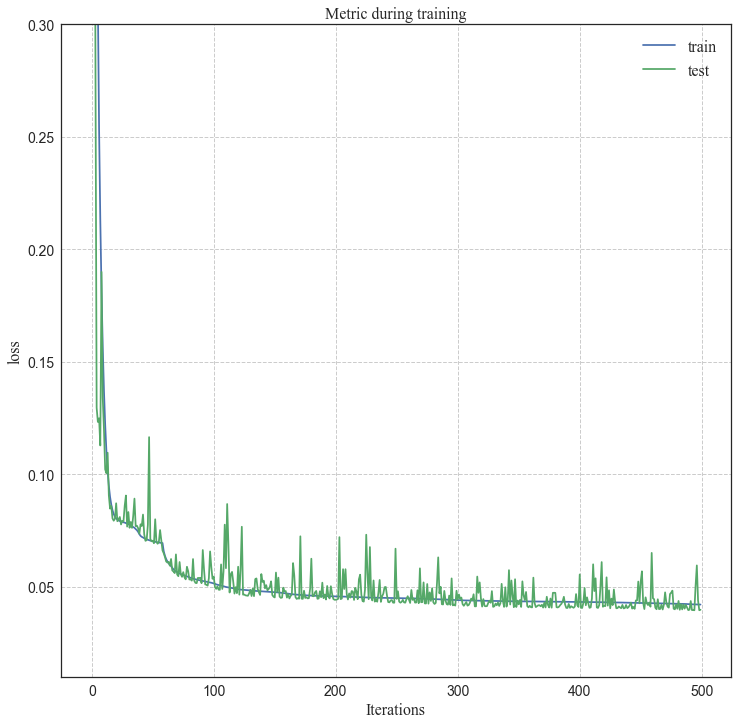

In [10]:
sns.set_style('white')
print('画出训练结果...')
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}
fig,ax = plt.subplots(figsize = (12,12))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
plt.ylabel('loss',font)
plt.xlabel('Iterations',font)
plt.xticks(fontsize=14,fontweight='normal') #默认字体大小为10
plt.yticks(fontsize=14,fontweight='normal')
ax.set_ylim(0.01, 0.3)
plt.grid(linestyle = '--')     # 添加网格线
plt.title('Metric during training',font)
plt.savefig('9none.jpg',dpi=600, bbox_inches = 'tight')
plt.legend(loc='best',prop = font)
plt.show()

In [11]:
model.save('DNN_model/dnn.h5')

In [9]:
#模型再训练（6月份新增的数据）
from keras.models import load_model
data_retrain = pd.read_csv("../data/data_retrain.csv")
data_retrain = data_retrain.dropna()
data_val = pd.read_csv("../data/data_val.csv")
data_val = data_val.dropna()
data_3 = data_val[:3600]
data = pd.concat([data_retrain,data_3])
print(data.shape)

(10954, 8)


Using TensorFlow backend.


In [10]:
data_la = data
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
data_la['soot'] = np.log1p(data_la['soot'])

In [11]:
features =  data_la.columns.values[0:7]   
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
data = data_la
n_train_days = int(len(data)*0.9)
data = data
#前80% 天的数据作为训练数据
train = data[:n_train_days]

#最后20%天的数据作为测试数据
test = data[n_train_days:]

In [12]:
train_X, train_y = train[features].values, train['soot'].values
train_y = train_y.reshape(train_y.shape[0],1)

test_X, test_y = test[features].values, test['soot'].values
test_y  = test_y.reshape(test_y.shape[0],1)
from sklearn import  preprocessing
train_X = preprocessing.scale(train_X)
test_X = preprocessing.scale(test_X)
print(test_X.shape,test_y.shape)

(1096, 7) (1096, 1)


In [13]:
from keras.layers import BatchNormalization
from keras.models import Sequential
#model = Sequential()
model = load_model('DNN_model/dnn.h5')
#model.add(BatchNormalization()) 
model.fit(train_X,train_y,batch_size = 100,epochs = 100,validation_data = (test_X,test_y))

C:\E_Disk\anaconda\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Train on 9858 samples, validate on 1096 samples
Epoch 1/100
9858/9858 [==============================] - 0s 48us/step - loss: 0.2010 - mean_absolute_error: 0.3004 - val_loss: 0.1699 - val_mean_absolute_error: 0.2956
Epoch 2/100
9858/9858 [==============================] - 0s 19us/step - loss: 0.2008 - mean_absolute_error: 0.2994 - val_loss: 0.1924 - val_mean_absolute_error: 0.3244
Epoch 3/100
9858/9858 [==============================] - 0s 19us/step - loss: 0.2004 - mean_absolute_error: 0.3001 - val_loss: 0.1707 - val_mean_absolute_error: 0.2965
Epoch 4/100
9858/9858 [==============================] - 0s 21us/step - loss: 0.2001 - mean_absolute_error: 0.2990 - val_loss: 0.1649 - val_mean_absolute_error: 0.2889
Epoch 5/100
9858/9858 [==============================] - 0s 21us/step - loss: 0.2014 - mean_absolute_error: 0.2996 - val_loss: 0.1723 - val_mean_absolute_error: 0.3025
Epoch 6/100
9858/9858 [==============================] - 0s 26us/step - loss: 0.2006 - mean_absolute_error: 0.29

9858/9858 [==============================] - 0s 21us/step - loss: 0.1991 - mean_absolute_error: 0.2976 - val_loss: 0.2180 - val_mean_absolute_error: 0.3452
Epoch 98/100
9858/9858 [==============================] - 0s 22us/step - loss: 0.1987 - mean_absolute_error: 0.2989 - val_loss: 0.1916 - val_mean_absolute_error: 0.3185
Epoch 99/100
9858/9858 [==============================] - 0s 19us/step - loss: 0.1987 - mean_absolute_error: 0.2986 - val_loss: 0.1999 - val_mean_absolute_error: 0.3247
Epoch 100/100
9858/9858 [==============================] - 0s 23us/step - loss: 0.1986 - mean_absolute_error: 0.2981 - val_loss: 0.2403 - val_mean_absolute_error: 0.3688


In [14]:
model.evaluate(test_X,test_y)

1096/1096 [==============================] - 0s 37us/step


[0.24025178069833422, 0.36883008512702303]

In [18]:
model.save('DNN_model/dnn_rein.h5')

In [19]:
#保存参数/加载参数
model.save_weights('DNN_model/dnn_rein_weights.h5')
model.load_weights('DNN_model/dnn_rein_weights.h5')

In [20]:
#保存网络结构
from keras.models import model_from_json
json_string = model.to_json()
model = model_from_json(json_string)
print(json_string)

{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 7], "dtype": "float32", "units": 7, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Activation", "config": {"name": "activation_1", "trainable": true, "activation": "relu"}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 7, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_n

In [ ]:
#计算预测值和实际值之间的均方根误差
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import load_model
test = pd.read_csv('../data/data_val_fin.csv')
features =  test.columns.values[0:7]   
test = test[features].values
from sklearn import  preprocessing
test = preprocessing.scale(test)
#test = test.reshape((test.shape[0], 1, test.shape[1]))
model = load_model('DNN_model/dnn_fin.h5')
model.load_weights('DNN_model/dnn_weights.h5')
predictions = model.predict(test)
rnn_pred = np.expm1(predictions)

In [25]:
rnn_pred = rnn_pred.reshape(6475)
sub = pd.DataFrame()
sub['soot'] = rnn_pred
sub.to_csv('DNN_model/submission_mse_dnn.csv',index=False)